# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

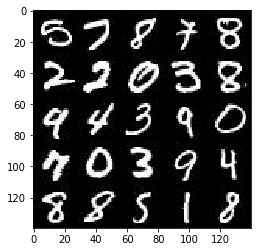

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

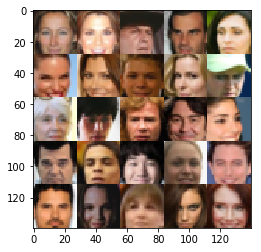

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width  --> 28
    :param image_height: The input image height --> 28
    :param image_channels: The number of image channels --> 3
    :param z_dim: The dimension of Z --> 100
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    tensor_real_imput_img = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    tensor_z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return (tensor_real_imput_img, tensor_z_data, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)--> Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer --> 28, 28, 3
        start_dim = 32
        kernel_sz = 5
        strides = 2
        
        layer_0 = tf.layers.conv2d(images, start_dim, kernel_sz, strides=strides, padding='same')
        relu_0 = tf.maximum(alpha * layer_0, layer_0)
        #0 --> ?, 10, 10, 64
        #14*14*64
        
        layer_1 = tf.layers.conv2d(layer_0, start_dim*2, kernel_sz, strides=strides, padding='same')
        batchnorm_1 = tf.layers.batch_normalization(layer_1, training=True)
        relu_1 = tf.maximum(alpha * layer_1, layer_1)
        #  7, 7, 128
        
        layer_2 = tf.layers.conv2d(layer_1, start_dim*4, kernel_sz, strides=strides, padding='same')
        batchnorm_2 = tf.layers.batch_normalization(layer_2, training=True)
        relu_2 = tf.maximum(alpha * layer_2, layer_2)
        #4, 4, 256
        
        flatten = tf.reshape(relu_2, (-1, (4*4*(start_dim*4)))) # --> (?, 2048)
        
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return (output, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z --> Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
    :param out_channel_dim: The number of channels in the output image --> 5
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        start_dim = 512
        kernel_sz = 5
        strides = 2
        #100
        layer_0 = tf.layers.dense(z, 7*7*start_dim)
    
        layer_0 = tf.reshape(layer_0, (-1, 7, 7, start_dim))
        layer_0 = tf.layers.batch_normalization(layer_0, training=is_train)
        # 7, 7, 512 
      
        layer_1 = tf.layers.conv2d_transpose(layer_0, int(start_dim/2), kernel_sz, strides=strides, padding='same')
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        relu_1 = tf.maximum(alpha * layer_1, layer_1)
        # 14, 14, 256
    
        layer_2 = tf.layers.conv2d_transpose(layer_1, int(start_dim/4), kernel_sz, strides=strides, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        relu_2 = tf. maximum(alpha * layer_2, layer_2)
        # 28, 28, 128
    
        logits = tf.layers.conv2d_transpose(layer_2, out_channel_dim, kernel_sz, strides=strides, padding='same')
        logits = tf.reshape(logits, (-1, 28, 28, out_channel_dim))
        output = tf.tanh(logits)
        # 28,28,5
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    alpha=0.2
    
    #generator with z input
    g_mod = generator(input_z, out_channel_dim, alpha=alpha)
    
    # discriminator with real input and g_mod output
    d_out_real, d_log_real = discriminator(input_real, alpha=alpha)
    d_out_fake, d_log_fake = discriminator(g_mod, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
                                tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_log_real,
                                    labels=tf.ones_like(d_out_real)
                                 ))
    
    d_loss_fake = tf.reduce_mean(
                                tf.nn.sigmoid_cross_entropy_with_logits(
                                logits=d_log_fake,
                                labels=tf.zeros_like(d_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_log_fake,
                                                                 labels=tf.ones_like(d_out_fake)))
    
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer --> 0.9 (eg less than 1)
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    
    #variable generators with shape (3,3), float32
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_op = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_op, g_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches,
          data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension --> 100
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data  --> (60000, 28, 28, 1)
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    div_by = 20
    n_images = 10
    image_mode="RGB"
    samples=[]
    
    input_real, input_z, lr = model_inputs(data_shape[1], 
                                                      data_shape[2], 
                                                      data_shape[3], 
                                                      z_dim)
    # --> Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32) 
    # Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
    # Tensor("Placeholder_2:0", dtype=float32)
            
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    # --> Tensor("add:0", shape=(), dtype=float32), Tensor("Mean_2:0", shape=(), dtype=float32) 
    
    d_train_op, g_train_op = model_opt(d_loss, g_loss, learning_rate, beta1)
     

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # sample random noise
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # engage optimizers for discriminator and generator
                _ = sess.run(d_train_op, feed_dict={input_real: batch_images,
                                                    input_z: z_batch, 
                                                    lr:learning_rate})
                _ = sess.run(g_train_op, feed_dict={input_real: batch_images,
                                                    input_z: z_batch,
                                                    lr: learning_rate})
        
                batch_images = batch_images * 2
            
                # get losses for printing every n steps
                if steps % 20 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: z_batch})
                    g_train_loss = g_loss.eval({input_z: z_batch})

                    print("Epoch {}/{} {} steps".format(epoch_i+1, epochs, steps), 
                         "- training losses: "
                         " discriminator: {:.4f}".format(d_train_loss),
                         "| generator {:.4f}".format(g_train_loss))
                    
                    if steps % 100 == 0:
                        if data_shape[3] == 1:
                            image_mode= "L"
                        show_generator_output(sess, n_images, input_z, data_shape[3], image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 20 steps - training losses:  discriminator: 0.9644 | generator 0.8641
Epoch 1/2 40 steps - training losses:  discriminator: 0.7905 | generator 1.2613
Epoch 1/2 60 steps - training losses:  discriminator: 0.6344 | generator 1.5855
Epoch 1/2 80 steps - training losses:  discriminator: 2.9001 | generator 0.8094
Epoch 1/2 100 steps - training losses:  discriminator: 2.5913 | generator 1.1897


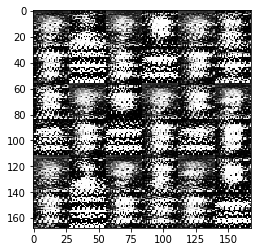

Epoch 1/2 120 steps - training losses:  discriminator: 2.2598 | generator 0.8237
Epoch 1/2 140 steps - training losses:  discriminator: 1.6303 | generator 1.0186
Epoch 1/2 160 steps - training losses:  discriminator: 1.9698 | generator 1.3131
Epoch 1/2 180 steps - training losses:  discriminator: 1.8135 | generator 0.9965
Epoch 1/2 200 steps - training losses:  discriminator: 2.2739 | generator 0.8746


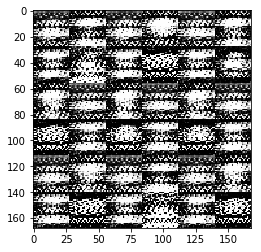

Epoch 1/2 220 steps - training losses:  discriminator: 1.9224 | generator 0.8285
Epoch 1/2 240 steps - training losses:  discriminator: 1.5414 | generator 0.7958
Epoch 1/2 260 steps - training losses:  discriminator: 2.0199 | generator 1.0305
Epoch 1/2 280 steps - training losses:  discriminator: 1.3608 | generator 1.1278
Epoch 1/2 300 steps - training losses:  discriminator: 0.5389 | generator 1.4832


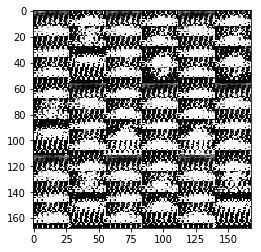

Epoch 1/2 320 steps - training losses:  discriminator: 0.5679 | generator 2.1609
Epoch 1/2 340 steps - training losses:  discriminator: 1.4543 | generator 1.2709
Epoch 1/2 360 steps - training losses:  discriminator: 1.0961 | generator 1.7578
Epoch 1/2 380 steps - training losses:  discriminator: 0.8686 | generator 2.0811
Epoch 1/2 400 steps - training losses:  discriminator: 1.2295 | generator 2.4058


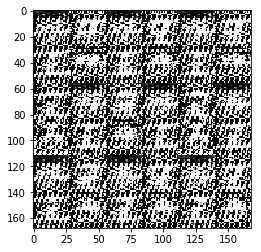

Epoch 1/2 420 steps - training losses:  discriminator: 0.8245 | generator 1.4577
Epoch 1/2 440 steps - training losses:  discriminator: 0.5110 | generator 1.7757
Epoch 1/2 460 steps - training losses:  discriminator: 1.0462 | generator 1.0774
Epoch 1/2 480 steps - training losses:  discriminator: 1.4651 | generator 1.3599
Epoch 1/2 500 steps - training losses:  discriminator: 1.1442 | generator 1.3429


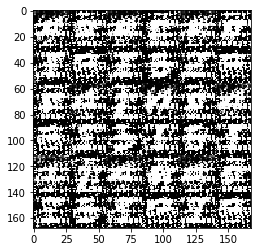

Epoch 1/2 520 steps - training losses:  discriminator: 1.7520 | generator 1.2509
Epoch 1/2 540 steps - training losses:  discriminator: 1.5285 | generator 1.3980
Epoch 1/2 560 steps - training losses:  discriminator: 1.2551 | generator 1.3567
Epoch 1/2 580 steps - training losses:  discriminator: 1.8132 | generator 1.2553
Epoch 1/2 600 steps - training losses:  discriminator: 1.2760 | generator 1.3898


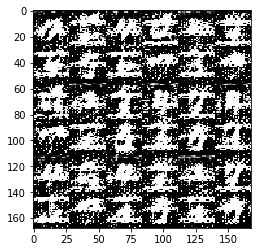

Epoch 1/2 620 steps - training losses:  discriminator: 2.9484 | generator 2.1371
Epoch 1/2 640 steps - training losses:  discriminator: 2.0705 | generator 1.6031
Epoch 1/2 660 steps - training losses:  discriminator: 3.1174 | generator 1.9925
Epoch 1/2 680 steps - training losses:  discriminator: 3.2119 | generator 1.9503
Epoch 1/2 700 steps - training losses:  discriminator: 2.6682 | generator 1.2179


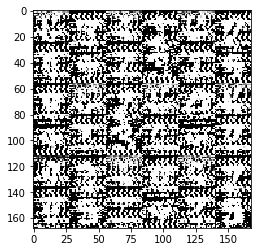

Epoch 1/2 720 steps - training losses:  discriminator: 2.8267 | generator 1.9913
Epoch 1/2 740 steps - training losses:  discriminator: 2.6271 | generator 2.2195
Epoch 1/2 760 steps - training losses:  discriminator: 3.2845 | generator 2.6079
Epoch 1/2 780 steps - training losses:  discriminator: 3.0541 | generator 1.3419
Epoch 1/2 800 steps - training losses:  discriminator: 0.5182 | generator 1.4100


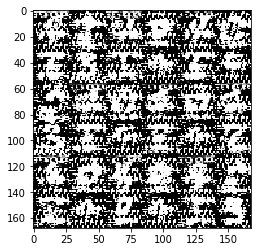

Epoch 1/2 820 steps - training losses:  discriminator: 1.7194 | generator 2.3081
Epoch 1/2 840 steps - training losses:  discriminator: 1.8181 | generator 2.3904
Epoch 1/2 860 steps - training losses:  discriminator: 1.9235 | generator 1.9590
Epoch 1/2 880 steps - training losses:  discriminator: 3.0052 | generator 2.3355
Epoch 1/2 900 steps - training losses:  discriminator: 2.7774 | generator 1.8762


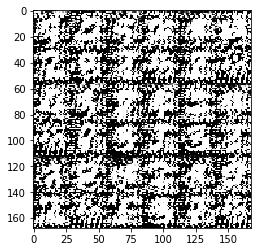

Epoch 1/2 920 steps - training losses:  discriminator: 3.1121 | generator 2.2362
Epoch 2/2 940 steps - training losses:  discriminator: 3.1355 | generator 2.4297
Epoch 2/2 960 steps - training losses:  discriminator: 5.6742 | generator 2.3206
Epoch 2/2 980 steps - training losses:  discriminator: 5.1102 | generator 2.4927
Epoch 2/2 1000 steps - training losses:  discriminator: 5.9884 | generator 3.1330


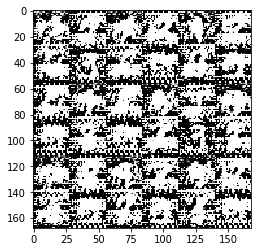

Epoch 2/2 1020 steps - training losses:  discriminator: 4.7749 | generator 2.7409
Epoch 2/2 1040 steps - training losses:  discriminator: 5.9266 | generator 2.8007
Epoch 2/2 1060 steps - training losses:  discriminator: 11.2398 | generator 4.3474
Epoch 2/2 1080 steps - training losses:  discriminator: 0.4009 | generator 3.6589
Epoch 2/2 1100 steps - training losses:  discriminator: 0.3396 | generator 1.8120


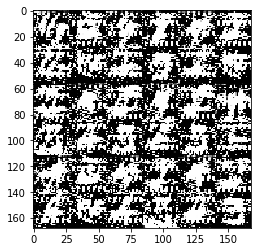

Epoch 2/2 1120 steps - training losses:  discriminator: 0.9458 | generator 1.9932
Epoch 2/2 1140 steps - training losses:  discriminator: 1.9017 | generator 1.8736
Epoch 2/2 1160 steps - training losses:  discriminator: 1.3505 | generator 3.0163
Epoch 2/2 1180 steps - training losses:  discriminator: 0.6770 | generator 2.3557
Epoch 2/2 1200 steps - training losses:  discriminator: 1.1310 | generator 2.3134


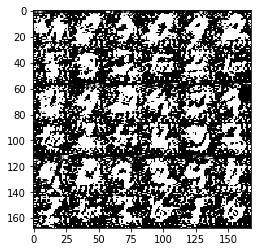

Epoch 2/2 1220 steps - training losses:  discriminator: 0.7546 | generator 1.9539
Epoch 2/2 1240 steps - training losses:  discriminator: 0.5063 | generator 2.6256
Epoch 2/2 1260 steps - training losses:  discriminator: 2.5826 | generator 2.8303
Epoch 2/2 1280 steps - training losses:  discriminator: 2.3862 | generator 2.3259
Epoch 2/2 1300 steps - training losses:  discriminator: 2.3155 | generator 2.6481


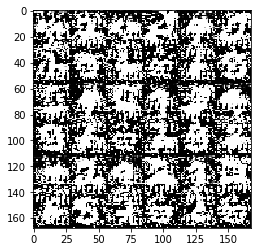

Epoch 2/2 1320 steps - training losses:  discriminator: 3.2293 | generator 3.1672
Epoch 2/2 1340 steps - training losses:  discriminator: 4.5194 | generator 3.3315
Epoch 2/2 1360 steps - training losses:  discriminator: 0.5326 | generator 3.5908
Epoch 2/2 1380 steps - training losses:  discriminator: 2.4473 | generator 1.8837
Epoch 2/2 1400 steps - training losses:  discriminator: 3.2741 | generator 2.2117


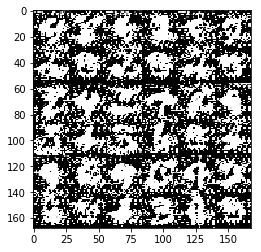

Epoch 2/2 1420 steps - training losses:  discriminator: 4.3725 | generator 2.9971
Epoch 2/2 1440 steps - training losses:  discriminator: 3.4902 | generator 1.3462
Epoch 2/2 1460 steps - training losses:  discriminator: 5.2269 | generator 2.7800
Epoch 2/2 1480 steps - training losses:  discriminator: 4.9838 | generator 2.4009
Epoch 2/2 1500 steps - training losses:  discriminator: 6.1765 | generator 2.7825


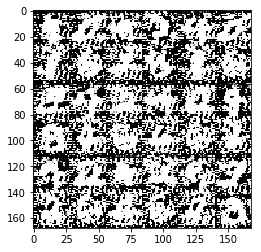

Epoch 2/2 1520 steps - training losses:  discriminator: 6.0982 | generator 2.9718
Epoch 2/2 1540 steps - training losses:  discriminator: 5.6942 | generator 2.6032
Epoch 2/2 1560 steps - training losses:  discriminator: 6.8636 | generator 2.5804
Epoch 2/2 1580 steps - training losses:  discriminator: 7.2369 | generator 3.2640
Epoch 2/2 1600 steps - training losses:  discriminator: 9.6751 | generator 0.0361


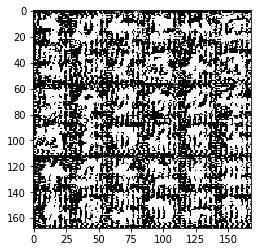

Epoch 2/2 1620 steps - training losses:  discriminator: 0.2303 | generator 2.1785
Epoch 2/2 1640 steps - training losses:  discriminator: 1.0176 | generator 3.1455
Epoch 2/2 1660 steps - training losses:  discriminator: 2.0604 | generator 1.7963
Epoch 2/2 1680 steps - training losses:  discriminator: 1.2560 | generator 3.0834
Epoch 2/2 1700 steps - training losses:  discriminator: 0.4513 | generator 2.5135


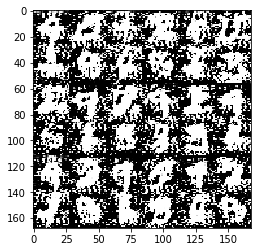

Epoch 2/2 1720 steps - training losses:  discriminator: 1.7941 | generator 3.3462
Epoch 2/2 1740 steps - training losses:  discriminator: 2.4517 | generator 2.9176
Epoch 2/2 1760 steps - training losses:  discriminator: 1.2277 | generator 2.5243
Epoch 2/2 1780 steps - training losses:  discriminator: 1.3159 | generator 2.3870
Epoch 2/2 1800 steps - training losses:  discriminator: 2.0972 | generator 2.6587


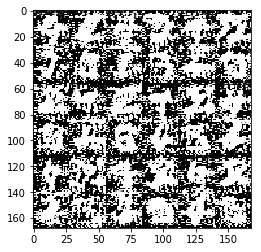

Epoch 2/2 1820 steps - training losses:  discriminator: 2.1293 | generator 2.2704
Epoch 2/2 1840 steps - training losses:  discriminator: 1.8142 | generator 2.8891
Epoch 2/2 1860 steps - training losses:  discriminator: 2.8885 | generator 2.6886


In [12]:
batch_size = 64 #75
z_dim = 90
learning_rate = 0.001 #0.005 #0.001
beta1 = 0.5
#Epoch 2/2 1600 steps - training losses:  discriminator: 4.8702 | generator 3.4759
#Epoch 2/2 1600 steps - training losses:  discriminator: 158.7141 | generator 126.9036

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 20 steps - training losses:  discriminator: 0.0527 | generator 4.2898
Epoch 1/1 40 steps - training losses:  discriminator: 1.8506 | generator 4.1267
Epoch 1/1 60 steps - training losses:  discriminator: 33.5304 | generator 20.0716
Epoch 1/1 80 steps - training losses:  discriminator: 2.2713 | generator 7.2994
Epoch 1/1 100 steps - training losses:  discriminator: 2.0602 | generator 1.4842


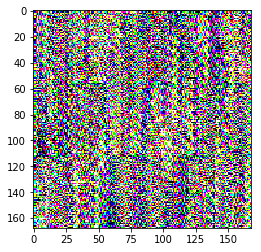

Epoch 1/1 120 steps - training losses:  discriminator: 11.5307 | generator 8.8411
Epoch 1/1 140 steps - training losses:  discriminator: 1.8855 | generator 7.0142
Epoch 1/1 160 steps - training losses:  discriminator: 1.3450 | generator 8.8656
Epoch 1/1 180 steps - training losses:  discriminator: 1.7130 | generator 8.9528
Epoch 1/1 200 steps - training losses:  discriminator: 1.2118 | generator 10.1731


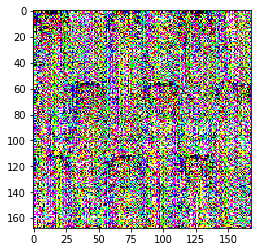

Epoch 1/1 220 steps - training losses:  discriminator: 1.0255 | generator 9.4815
Epoch 1/1 240 steps - training losses:  discriminator: 1.9226 | generator 7.3570
Epoch 1/1 260 steps - training losses:  discriminator: 1.4973 | generator 6.5466
Epoch 1/1 280 steps - training losses:  discriminator: 0.8156 | generator 7.2385
Epoch 1/1 300 steps - training losses:  discriminator: 0.6624 | generator 6.0981


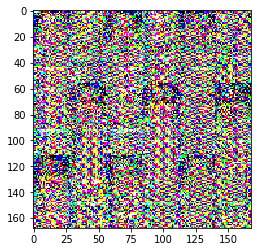

Epoch 1/1 320 steps - training losses:  discriminator: 7.4024 | generator 8.4465
Epoch 1/1 340 steps - training losses:  discriminator: 1.7003 | generator 7.1075
Epoch 1/1 360 steps - training losses:  discriminator: 1.7775 | generator 6.6945
Epoch 1/1 380 steps - training losses:  discriminator: 1.9048 | generator 4.2059
Epoch 1/1 400 steps - training losses:  discriminator: 2.0015 | generator 5.0721


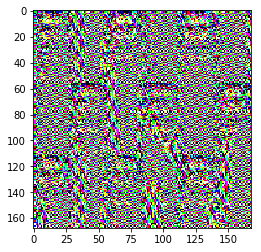

Epoch 1/1 420 steps - training losses:  discriminator: 1.0474 | generator 5.5713
Epoch 1/1 440 steps - training losses:  discriminator: 1.0774 | generator 6.4050
Epoch 1/1 460 steps - training losses:  discriminator: 1.3700 | generator 4.5371
Epoch 1/1 480 steps - training losses:  discriminator: 0.9129 | generator 4.2615
Epoch 1/1 500 steps - training losses:  discriminator: 0.8848 | generator 2.6522


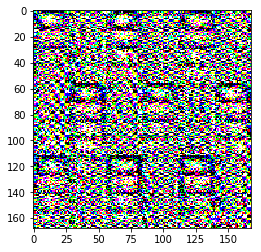

Epoch 1/1 520 steps - training losses:  discriminator: 0.9504 | generator 2.8478
Epoch 1/1 540 steps - training losses:  discriminator: 1.0129 | generator 2.4740
Epoch 1/1 560 steps - training losses:  discriminator: 0.6566 | generator 3.8127
Epoch 1/1 580 steps - training losses:  discriminator: 0.4713 | generator 4.2533
Epoch 1/1 600 steps - training losses:  discriminator: 0.4511 | generator 2.9488


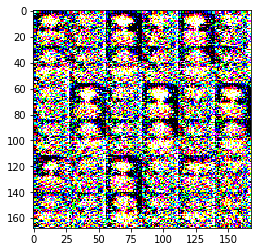

Epoch 1/1 620 steps - training losses:  discriminator: 0.3704 | generator 4.3606
Epoch 1/1 640 steps - training losses:  discriminator: 0.3077 | generator 3.6332
Epoch 1/1 660 steps - training losses:  discriminator: 0.2523 | generator 3.2045
Epoch 1/1 680 steps - training losses:  discriminator: 0.0913 | generator 5.6066
Epoch 1/1 700 steps - training losses:  discriminator: 0.2486 | generator 4.4755


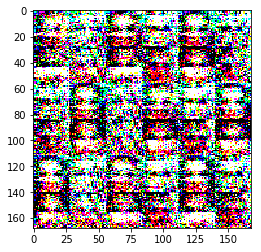

Epoch 1/1 720 steps - training losses:  discriminator: 0.1471 | generator 4.6685
Epoch 1/1 740 steps - training losses:  discriminator: 18.3048 | generator 1.9023
Epoch 1/1 760 steps - training losses:  discriminator: 4185.1421 | generator 2305.6177
Epoch 1/1 780 steps - training losses:  discriminator: 494.1579 | generator 3081.0559
Epoch 1/1 800 steps - training losses:  discriminator: 78.1146 | generator 2131.0620


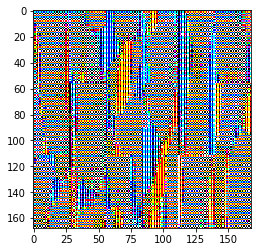

Epoch 1/1 820 steps - training losses:  discriminator: 31.4437 | generator 2258.2693
Epoch 1/1 840 steps - training losses:  discriminator: 84.9992 | generator 1117.5221
Epoch 1/1 860 steps - training losses:  discriminator: 43.3718 | generator 1569.1035
Epoch 1/1 880 steps - training losses:  discriminator: 48.4478 | generator 1879.1569
Epoch 1/1 900 steps - training losses:  discriminator: 40.5242 | generator 1504.3904


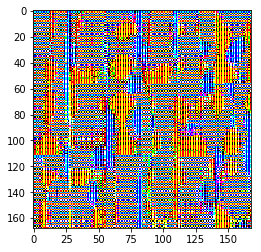

Epoch 1/1 920 steps - training losses:  discriminator: 32.8615 | generator 1148.1299
Epoch 1/1 940 steps - training losses:  discriminator: 30.9595 | generator 950.4510
Epoch 1/1 960 steps - training losses:  discriminator: 42.6712 | generator 1025.3055
Epoch 1/1 980 steps - training losses:  discriminator: 83.2017 | generator 713.6350
Epoch 1/1 1000 steps - training losses:  discriminator: 46.7133 | generator 740.4031


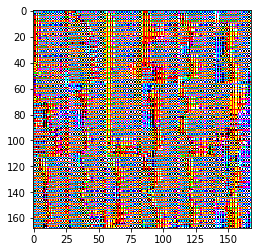

Epoch 1/1 1020 steps - training losses:  discriminator: 78.5782 | generator 609.8217
Epoch 1/1 1040 steps - training losses:  discriminator: 107.6039 | generator 384.4720
Epoch 1/1 1060 steps - training losses:  discriminator: 116.2517 | generator 386.6171
Epoch 1/1 1080 steps - training losses:  discriminator: 93.8387 | generator 183.5632
Epoch 1/1 1100 steps - training losses:  discriminator: 163.3852 | generator 236.8818


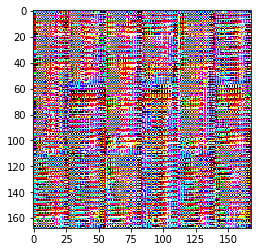

Epoch 1/1 1120 steps - training losses:  discriminator: 120.8980 | generator 214.5735
Epoch 1/1 1140 steps - training losses:  discriminator: 240.7414 | generator 355.1338
Epoch 1/1 1160 steps - training losses:  discriminator: 135.6461 | generator 185.7677
Epoch 1/1 1180 steps - training losses:  discriminator: 97.2950 | generator 299.6047
Epoch 1/1 1200 steps - training losses:  discriminator: 89.1165 | generator 180.9642


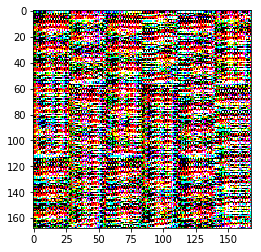

Epoch 1/1 1220 steps - training losses:  discriminator: 105.6111 | generator 169.0712
Epoch 1/1 1240 steps - training losses:  discriminator: 92.3524 | generator 130.4781
Epoch 1/1 1260 steps - training losses:  discriminator: 59.4850 | generator 331.1639
Epoch 1/1 1280 steps - training losses:  discriminator: 60.3576 | generator 125.2007
Epoch 1/1 1300 steps - training losses:  discriminator: 55.5328 | generator 114.0757


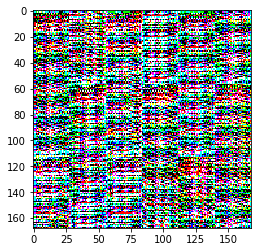

Epoch 1/1 1320 steps - training losses:  discriminator: 6.8701 | generator 277.6186
Epoch 1/1 1340 steps - training losses:  discriminator: 54.2804 | generator 122.7060
Epoch 1/1 1360 steps - training losses:  discriminator: 22.6040 | generator 434.2043
Epoch 1/1 1380 steps - training losses:  discriminator: 10.3412 | generator 172.9476
Epoch 1/1 1400 steps - training losses:  discriminator: 23.6904 | generator 103.0297


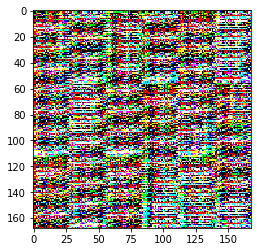

Epoch 1/1 1420 steps - training losses:  discriminator: 31.4405 | generator 123.2883
Epoch 1/1 1440 steps - training losses:  discriminator: 30.6796 | generator 127.0278
Epoch 1/1 1460 steps - training losses:  discriminator: 26.1671 | generator 98.7259
Epoch 1/1 1480 steps - training losses:  discriminator: 29.7014 | generator 190.3132
Epoch 1/1 1500 steps - training losses:  discriminator: 8.6476 | generator 308.0956


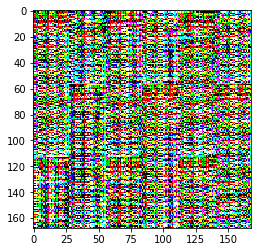

Epoch 1/1 1520 steps - training losses:  discriminator: 17.5648 | generator 136.1663
Epoch 1/1 1540 steps - training losses:  discriminator: 9.1923 | generator 192.5837
Epoch 1/1 1560 steps - training losses:  discriminator: 14.2741 | generator 76.0324
Epoch 1/1 1580 steps - training losses:  discriminator: 16.3892 | generator 158.5049
Epoch 1/1 1600 steps - training losses:  discriminator: 8.5484 | generator 94.8173


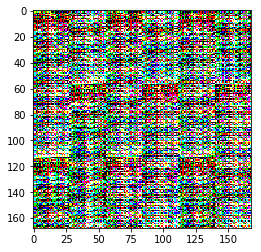

Epoch 1/1 1620 steps - training losses:  discriminator: 5.3597 | generator 118.0515
Epoch 1/1 1640 steps - training losses:  discriminator: 3.7915 | generator 63.9847
Epoch 1/1 1660 steps - training losses:  discriminator: 1.6602 | generator 85.8769
Epoch 1/1 1680 steps - training losses:  discriminator: 5.5851 | generator 74.6097
Epoch 1/1 1700 steps - training losses:  discriminator: 4.2312 | generator 1048.8926


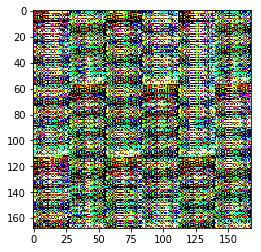

Epoch 1/1 1720 steps - training losses:  discriminator: 2.7939 | generator 94.6280
Epoch 1/1 1740 steps - training losses:  discriminator: 0.2834 | generator 132.8596
Epoch 1/1 1760 steps - training losses:  discriminator: 6.0798 | generator 71.7540
Epoch 1/1 1780 steps - training losses:  discriminator: 6.9026 | generator 493.1419
Epoch 1/1 1800 steps - training losses:  discriminator: 7.6907 | generator 236.5176


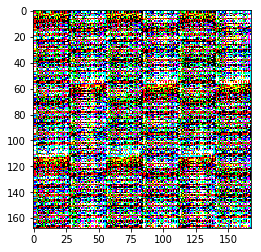

Epoch 1/1 1820 steps - training losses:  discriminator: 3.7187 | generator 66.3764
Epoch 1/1 1840 steps - training losses:  discriminator: 11.5483 | generator 196.8122
Epoch 1/1 1860 steps - training losses:  discriminator: 36.8834 | generator 117.9125
Epoch 1/1 1880 steps - training losses:  discriminator: 48.3636 | generator 107.6673
Epoch 1/1 1900 steps - training losses:  discriminator: 11.0966 | generator 537.1816


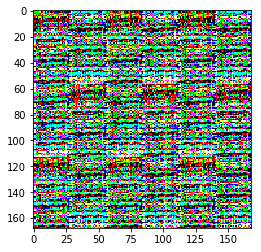

Epoch 1/1 1920 steps - training losses:  discriminator: 21.5376 | generator 74.3032
Epoch 1/1 1940 steps - training losses:  discriminator: 22.4475 | generator 82.2992
Epoch 1/1 1960 steps - training losses:  discriminator: 13.1111 | generator 100.3993
Epoch 1/1 1980 steps - training losses:  discriminator: 29.5419 | generator 166.1433
Epoch 1/1 2000 steps - training losses:  discriminator: 4.3445 | generator 51.8144


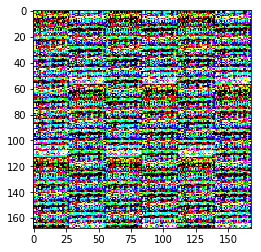

Epoch 1/1 2020 steps - training losses:  discriminator: 17.2905 | generator 53.6980


In [13]:
batch_size = 100 #64 #128
z_dim = 100 #100 #110
learning_rate =  0.005 ##0.0005
beta1 = 0.5 #0.4

#Epoch 1/1 1580 steps - training losses:  discriminator: 0.7630 | generator 5.3722 - stopped earlly
#Epoch 1/1 3000 steps - training losses:  discriminator: 0.1074 | generator 6.1110
#Epoch 1/1 2360 steps - training losses:  discriminator: 233.2417 | generator 613.2948 - stopped early
#Epoch 1/1 540 steps - training losses:  discriminator: 4.4537 | generator 59.3181 - stopped early

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.